# Object Detection
## 模型介绍：OwlViT（Open-Vocabulary Object Detection with Vision Transformers）

### 1. 模型概述
OwlViT（Open-vocabulary Vision Transformer）是 Google Research 在 2022 年提出的一种 **开放词汇目标检测模型**。  
与传统检测模型（如 Faster R-CNN、DETR 等）仅能检测预定义类别不同，OwlViT 能够通过**自然语言描述（Text Prompt）**进行任意目标检测。

换言之，用户无需在训练阶段指定固定的类别标签，只需在推理时输入提示词（如 *"a cat"*, *"a red car"*, *"a person wearing glasses"*），模型即可检测出符合描述的目标区域。

OwlViT 的核心思想是将 **视觉表示（Vision Embedding）** 与 **文本表示（Text Embedding）** 映射到同一语义空间，通过 **跨模态相似度匹配** 来完成开放类别检测任务。

---

### 2. 模型结构

OwlViT 由两大模块组成：

#### 视觉编码器（Vision Encoder）
- 使用 **ViT（Vision Transformer）** 作为骨干网络（Backbone），例如 ViT-B/32、ViT-L/14。
- 输入图像被划分为固定大小的 patch（如 32×32），经过 Transformer 编码得到全局特征。
- 输出为一组视觉 token，用于后续与文本特征进行匹配。

#### 文本编码器（Text Encoder）
- 文本部分基于 **CLIP 文本编码器**，将提示词（Prompt）转化为语义向量。
- 多个提示词（如 “a cat”, “a dog”）分别编码后，与视觉特征进行匹配计算。

#### 检测头（Detection Head）
- 模型通过计算图像区域特征与文本特征之间的相似度，输出一组候选框（Bounding Boxes）与类别置信度（Confidence Scores）。
- 后处理阶段会进行阈值筛选与非极大值抑制（NMS）以得到最终检测结果。

---

### 3. 推理流程

OwlViT 的推理过程分为以下几个步骤：

1. **文本与图像编码**  
   - 输入图像 → ViT → 视觉特征张量  
   - 输入提示词 → 文本编码器 → 语义向量表示

2. **跨模态相似度计算**  
   - 计算每个视觉区域与文本语义的余弦相似度（Cosine Similarity）

3. **框回归与筛选**  
   - 根据相似度阈值输出候选框、置信度与对应类别标签

---

### 4. 模型特点

| 特点 | 说明 |
|------|------|
| 开放词汇检测 | 可检测任意自然语言描述的物体，无需固定类别集 |
| 共享模态空间 | 图像与文本嵌入共享语义空间，具备强泛化能力 |
| 可扩展性强 | 可与 CLIP、ALIGN 等多模态模型结合 |
| 零样本识别 | 支持 *zero-shot detection*，无需额外微调 |

---


In [1]:
import mindspore.ops as ops

def _safe_log1p(x):
    try:
        return ops.log1p(x)
    except Exception as e:
        # 手动实现 log1p，防止溢出或下溢
        print(f"[SafeLog1p] Fallback triggered: {e}")
        return ops.log(ops.add(x, ms.Tensor(1.0, x.dtype)))
def _safe_bmm(x, y):
    x_shape = x.shape  
    y_shape = y.shape
    if len(y_shape) == 3 and y_shape[-2] == x_shape[-1]:
        y_use = y  
    else:
        y_use = ops.transpose(y, (0, 2, 1))
    return ops.matmul(x, y_use)

ops.bmm = _safe_bmm
ops.log1p = _safe_log1p

from mindnlp.transformers.models.owlvit import modeling_owlvit
modeling_owlvit.ops.log1p = _safe_log1p
modeling_owlvit.ops.bmm = _safe_bmm

/usr/local/miniconda3/envs/ob/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/ob/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/envs/ob/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/ob/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
[WARNING] ME(278201:246290198327328,MainProcess):2025-10-22-10:07:54.647.78 [m

In [2]:
from PIL import Image,ImageDraw
import mindspore as ms
from mindspore import ops, Tensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mindspore import context
from mindnlp.transformers.models.owlvit.modeling_owlvit import OwlViTForObjectDetection
from mindnlp.transformers.models.owlvit.processing_owlvit import OwlViTProcessor

import numpy as np

In [3]:
ms.set_device("Ascend")
print(f"Device: {context.get_context('device_target')}")

Device: Ascend


加载模型，首次加载可能较慢，需要耐心等待......

In [4]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model.set_train(False)

/usr/local/miniconda3/envs/ob/lib/python3.9/site-packages/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(
[WARNING] DEVICE(278201,dfff2a128120,python):2025-10-22-10:08:19.128.314 [mindspore/ccsrc/plugin/res_manager/ascend/mem_manager/ascend_memory_adapter.cc:123] Initialize] Free memory size is less than half of total memory size.Device 0 Device MOC total size:24823164928 Device MOC free size:6735523840 may be other processes occupying this card, check as: ps -ef|grep python
2025-10-22 10:08:54.296236: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute T which is not in the op definition: Op<name=StatelessRandomNormalV2; signature=shape:Tshape, key:uint64, counter:uint64, alg:int32 -> output:dtype; attr=dtype:type,default=DT_FLOAT,allowed=[DT_

[SafeLog1p] Fallback triggered: maximum recursion depth exceeded while calling a Python object[SafeLog1p] Fallback triggered: maximum recursion depth exceeded
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded while calling a Python object
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded in comparison
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded in comparison
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded in comparison
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded in comparison
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded while calling a Python object
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded in __instancecheck__
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded
[SafeLog1p] Fallback triggered: maximum recursion depth exceeded while calling a Python object
[SafeLog1p] Fallback tri

OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear (512 -> 512)
              (v_proj): Linear (512 -> 512)
              (q_proj): Linear (512 -> 512)
              (out_proj): Linear (512 -> 512)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELU()
              (fc1): Linear (512 -> 2048)
              (fc2): Linear (2048 -> 512)
            )
            (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (final_layer_norm): LayerNorm((512,), eps=1e-05, ele

In [5]:
image_path = "img.jpg"
image = Image.open(image_path).convert("RGB")
texts = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="ms")

In [6]:
outputs = model(**inputs)

.Detected a photo of a cat with confidence 0.714 at location [324.69, 20.16, 640.0, 373.36]
Detected a photo of a cat with confidence 0.724 at location [1.25, 55.31, 315.62, 472.03]


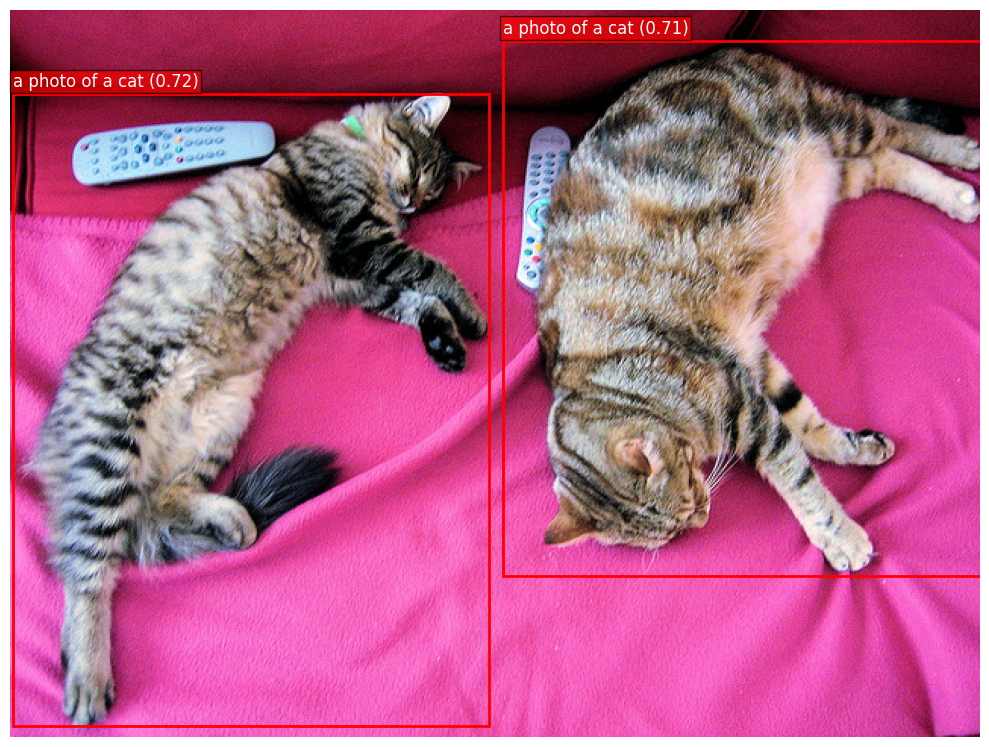

In [7]:
target_sizes = ms.Tensor([list(image.size)[::-1]], dtype=ms.float32)

results = processor.post_process_object_detection(
    outputs=outputs,
    threshold=0.1,
    target_sizes=target_sizes
)

i = 0
text = texts[i]
boxes = results[i]["boxes"]
scores = results[i]["scores"]
labels = results[i]["labels"]

# 创建画布
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

# 不同类别使用不同颜色
colors = [(1, 0, 0), (0, 1, 0)]


for box, score, label in zip(boxes, scores, labels):
    box = [round(float(x), 2) for x in box.asnumpy().tolist()]
    score = float(score.asnumpy())
    label = int(label.asnumpy())
    print(f"Detected {text[label]} with confidence {round(score, 3)} at location {box}")
        # 绘制边框
    x_min, y_min, x_max, y_max = box
    width, height = x_max - x_min, y_max - y_min
    color = colors[label % len(colors)]
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=color, facecolor='none'
    )
    ax.add_patch(rect)

    # 绘制标签与置信度
    label_text = f"{text[label]} ({score:.2f})"
    ax.text(
        x_min, y_min - 5, label_text,
        fontsize=12, color="white",
        bbox=dict(facecolor=color, alpha=0.7, pad=2)
    )

ax.axis("off")
plt.tight_layout()
plt.show()